In [62]:
import cantera as ct
import numpy as np
import csv

# %config InlineBackend.figure_formats = ["svg"]
%matplotlib inline
import matplotlib.pyplot as plt

print('running cantera version: ' + ct.__version__)

running cantera version: 3.0.0


In [63]:
gas = ct.Solution("data/ss_mech.yaml")

C:\Users\tahze\AppData\Local\Temp\ipykernel_24892\3607111391.py:1: UserWarning: NasaPoly2::validate: 
For species H2O, discontinuity in cp/R detected at Tmid = 18.01
	Value computed using low-temperature polynomial:  4.1640474673509615
	Value computed using high-temperature polynomial: 2.7303344722452962

  gas = ct.Solution("data/ss_mech.yaml")
C:\Users\tahze\AppData\Local\Temp\ipykernel_24892\3607111391.py:1: UserWarning: NasaPoly2::validate: 
For species H2O, discontinuity in h/RT detected at Tmid = 18.01
	Value computed using low-temperature polynomial:  -1677.869344773688
	Value computed using high-temperature polynomial: -1656.701813502562

  gas = ct.Solution("data/ss_mech.yaml")
C:\Users\tahze\AppData\Local\Temp\ipykernel_24892\3607111391.py:1: UserWarning: NasaPoly2::validate: 
For species H2O, discontinuity in s/R detected at Tmid = 18.01
	Value computed using low-temperature polynomial:  11.253302479772398
	Value computed using high-temperature polynomial: 14.675098919376222

In [64]:
reactor_T = 2050 # temp of AP premixed flame
reactor_P = 101325 # Pa

x = 85

Y_nh3 = x*17/117.46
Y_hclo4 = x*100.46/117.46
Y_c2h4 = 15

# n_NH3 = mass_percent_AP/117.49  # deflagration of AP (not gas phase)
# n_HCLO4 = n_NH3
# n_C2H4 = (100-mass_percent_AP)/28.00 # almost all HTPB decomposes into C2H4 at high temp of reactor

# phi = (2/0.523)/((2*n_NH3)/n_C2H4)


# density_AP = 1.95 # g/cc
# density_HTPB = 0.92 # g/cc
# rho = 0.01*(mass_percent_AP*density_AP + (100-mass_percent_AP)*density_HTPB)

# gas.set_equivalence_ratio(phi=phi, fuel="C2H4", oxidizer={"NH3": 1.0, "HCLO4": 1.0})

gas.TPY = reactor_T, reactor_P, f'NH3:{Y_nh3}, HCLO4:{Y_hclo4}, C2H4:{Y_c2h4}'

In [65]:
gas()


  gas:

       temperature   2050 K
          pressure   1.0132e+05 Pa
           density   0.30013 kg/m^3
  mean mol. weight   50.487 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy        2.3871e+06        1.2052e+08  J
   internal energy        2.0495e+06        1.0347e+08  J
           entropy            6908.4        3.4878e+05  J/K
    Gibbs function       -1.1775e+07       -5.9449e+08  J
 heat capacity c_p            1588.4             80193  J/K
 heat capacity c_v            1423.7             71878  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
              C2H4              0.15           0.26995           -33.953
               NH3           0.12302           0.36468           -32.963
             HCLO4           0.72698           0.36537           -37.473


In [66]:
initial_pressure = 1  # MPa
final_pressure = 10.0  # MPa
pressure_step = 0.01  # MPa
tem = []

In [67]:
def calculate_burn_rate(gas, pressure, temp, max_time=0.1):
    reactor = ct.IdealGasReactor(gas)
    gas.TP = temp, pressure * 1.0e6  # Convert pressure to Pa

    sim = ct.ReactorNet([reactor])

    rho = reactor.density

    # Track the progress of the reaction and time
    progress = []
    time = []

    while sim.time < max_time:
        sim.step()
        time.append(sim.time)
        progress.append((reactor.Y[gas.species_index('NH3')] + reactor.Y[gas.species_index('C2H4')] + reactor.Y[gas.species_index('HCLO4')])*reactor.mass*1000)

    # Calculate the burn rate (cm/s) based on progress and time
    # Use central difference method to calculate derivative
    delta_time = np.diff(time)
    delta_progress = np.diff(progress)
    burn_rate = abs(delta_progress) / abs(delta_time) # g/s

    burn_rate /= rho # cm3/s
    # considering a 0.85cm by 0.85cm square area, we can say this is the burn rate in cm/s
    burn_rate /= (0.85*0.85)

    return time, max(burn_rate)  # Return the initial burn rate

In [68]:
pressures = np.arange(initial_pressure, final_pressure, pressure_step)
burn_rates = []

for pressure in pressures:
    _, burn_rate = calculate_burn_rate(gas, pressure, reactor_T)
    burn_rates.append(burn_rate)

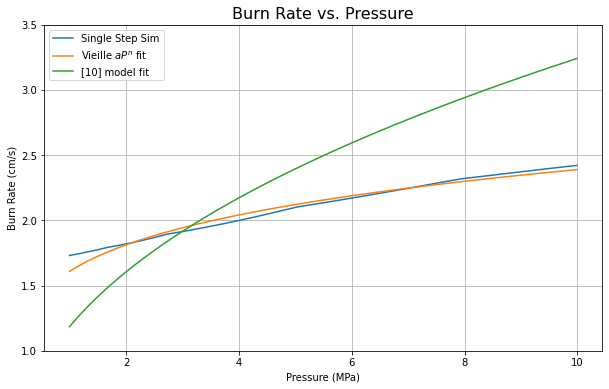

In [69]:
from scipy.optimize import curve_fit

# Plot the burn rate vs. pressure

def br_eqn(x, A, N):
    y = A * x**N
    return y

parameters, covariance = curve_fit(br_eqn, pressures, burn_rates)
fit_y = br_eqn(pressures, parameters[0], parameters[1])


# values from paper
def paper(p, A=2.83e-5, N=0.437):
    y = A * p**N
    return y*100

y = []
for i,p in enumerate(pressures):
    y.append(paper(p*1e6))


plt.figure(figsize=(10,6))

plt.plot(pressures, burn_rates, label = 'Single Step Sim')
plt.plot(pressures, fit_y, label = r'Vieille $a P^n$ fit')
plt.plot(pressures, y, label = '[10] model fit')

plt.xlabel('Pressure (MPa)')
plt.ylabel('Burn Rate (cm/s)')
plt.title('Burn Rate vs. Pressure', fontsize=16)
plt.ylim(1.0, 3.5)
plt.grid()
plt.legend()
plt.show()


In [70]:
print("a: ", parameters[0])
print("n: ", parameters[1])

a:  1.6087964490596278
n:  0.17173158626499263


In [71]:
gas()


  gas:

       temperature   2402.6 K
          pressure   1.3741e+05 Pa
           density   0.30013 kg/m^3
  mean mol. weight   43.634 kg/kmol
   phase of matter   gas

                          1 kg             1 kmol     
                     ---------------   ---------------
          enthalpy        2.5073e+06         1.094e+08  J
   internal energy        2.0495e+06        8.9428e+07  J
           entropy            7930.6        3.4604e+05  J/K
    Gibbs function       -1.6547e+07       -7.2201e+08  J
 heat capacity c_p            1704.6             74379  J/K
 heat capacity c_v            1514.1             66064  J/K

                      mass frac. Y      mole frac. X     chem. pot. / RT
                     ---------------   ---------------   ---------------
               H2O          0.042625           0.10324           -42.379
                O2          0.047435          0.064684           -31.867
                N2          0.010843          0.016888           -31.35